# Model

For denoising we have developed a model structure, which is shown below. We have used convolutional neural network model called autoencoder for our project. We have used this type because we needed at output the picture with same size as the one at input. 

At the beginning, we started to train our model with simple autoencoder, which was composed from one covolution layer, one maxpooling layer and one upsampling layer. After study process, we have applied methods of layer order from online articles. From this process we concluded that each convolution layer should be followed by a batch normalization layer, which normalize the activation from previous layer. We have added concatenate layer which groups main output from layer order with some individual layers for better detail at the end of layer assembly. In our project this skip connections had improved quality of output photos significantly. 

**Convolution layers**: We have used two types of convolutional layers: with 2x2 kernel size and with 3x3 kernel size. In earlier layers, we used 3x3 kernel sizes only, for the purpose of bigger noise presence at the begining of model layers.

**MaxPooling**: We have used 2x2 pool size max pooling layer to down-sample input image and reduce its dimensionality.

**UpSampling**: 2x2 size layer that will double the dimensions of input, to get a required output dimensionality after using MaxPooling layers

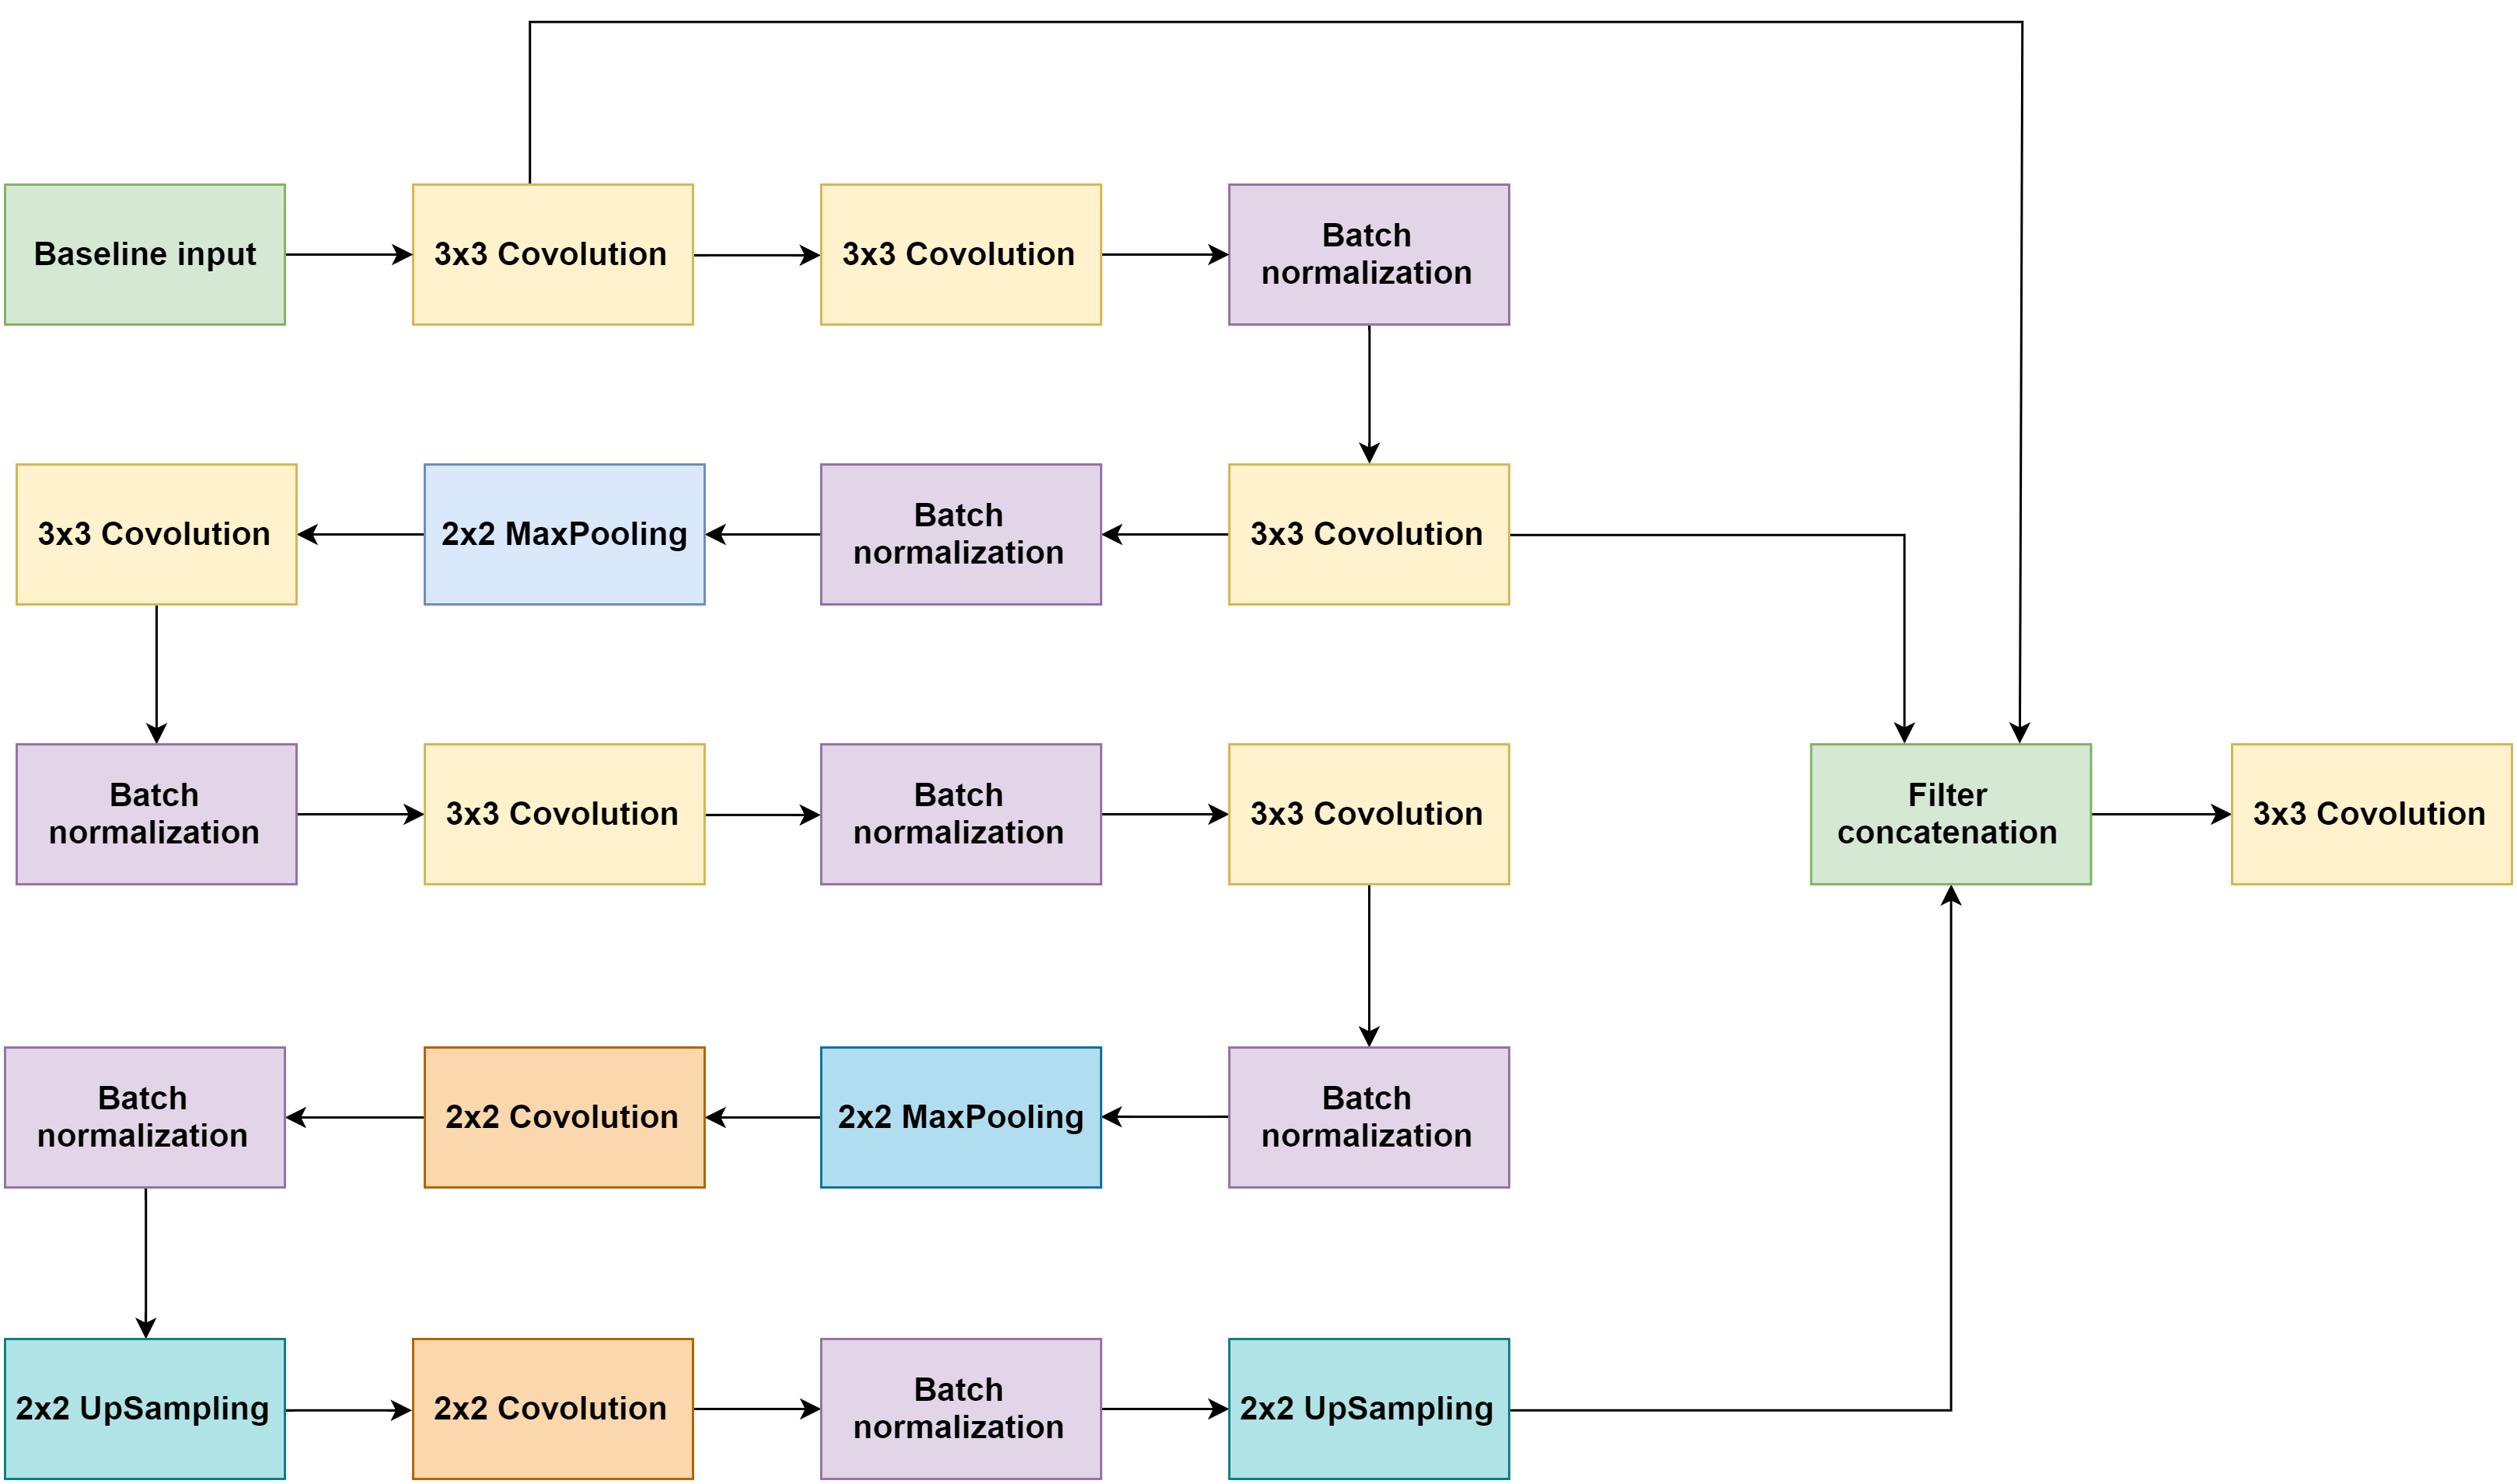

# Result of grayscale images denoising 

log directory: logs/2019-11-17-20-16

**FIRST ROW IS DENOISED**  
**SECOND ROW IS NOISED**  
**THIRD ROW IS ORIGINAL**

<img src="Pictures/1000_pictures.PNG">

# Result of rgb images denoising 

log directory: logs/2019-11-17-21-44

**FIRST ROW IS DENOISED**  
**SECOND ROW IS NOISED**  
**THIRD ROW IS ORIGINAL**

<img src="Pictures/rgb_denoise.PNG">


# Implementation

In [108]:
import tensorflow.keras as keras
import tensorflow.keras.layers as KL
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Sequential
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from zipfile import ZipFile

%load_ext autoreload
%autoreload 2

%matplotlib notebook

%load_ext tensorboard
%tensorboard --logdir logs --bind_all

sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 807), started 0:57:18 ago. (Use '!kill 807' to kill it.)

In [94]:
artifact_encoder = None;

### Current implementation is set to rgb denoising, by changing `rgb_or_grayscale` to `1` will change it to grayscale denoising

In [95]:
#Only some of them are constants, but renaming would take some time
class Constants:
    IMG_SIZE = 64 
    NUM_OF_PICTURES = 1000
    RGB_OR_GRAYSCALE = 3 # 1 for grayscale, 3 for rgb
    train_orig = []
    test_orig = []
    train_noised = []
    test_noised = []
    autoencoder = None

In [96]:
def set_initialization_variables(img_size, num_of_pictures, rgb_or_grayscale):
    Constants.IMG_SIZE = img_size 
    Constants.NUM_OF_PICTURES = num_of_pictures
    Constants.RGB_OR_GRAYSCALE = rgb_or_grayscale #3 # 1 for grayscale, 3 for rgb

#### We load rgb pictures and by constant RGB_OR_GRAYSCALE we determine if the model will be trained on rgb or grayscale images

In [97]:
def load_images(orig_path, changed_path):
    mypath_orig = orig_path
    mypath_noised = changed_path

    onlyfiles_orig = [f for f in listdir(mypath_orig) if isfile(join(mypath_orig, f))]
    onlyfiles_noised = [f for f in listdir(mypath_noised) if isfile(join(mypath_noised, f))]

    original_images = np.empty([Constants.NUM_OF_PICTURES,Constants.IMG_SIZE, Constants.IMG_SIZE, Constants.RGB_OR_GRAYSCALE])
    noised_images = np.empty([Constants.NUM_OF_PICTURES,Constants.IMG_SIZE, Constants.IMG_SIZE, Constants.RGB_OR_GRAYSCALE])

    iterationOrig = 0
    iterationNoised = 0
    print(onlyfiles_orig[1])
    for q in onlyfiles_orig[:Constants.NUM_OF_PICTURES]:
        name = mypath_orig +"/"+q
        original_images[iterationOrig] = image.img_to_array(image.load_img(name, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))
        original_images[iterationOrig] /= 255.0

        path = mypath_noised +"/"+ q
        noised_images[iterationOrig] = image.img_to_array(image.load_img(path, target_size=(Constants.IMG_SIZE, Constants.IMG_SIZE)))
        noised_images[iterationOrig] /= 255.0
        iterationOrig += 1
        #print("My path_orig:" + name + "  noised:" + path)
#     print(noised_images[299])
#     print(original_images.shape)
    split = int(Constants.NUM_OF_PICTURES*0.7)

    Constants.train_orig = original_images[:split]
    Constants.test_orig = original_images[split:]

    Constants.train_noised = noised_images[:split]
    Constants.test_noised = noised_images[split:]

In [98]:
def show_image_in_plot(ax, img):
    if Constants.RGB_OR_GRAYSCALE == 1:
        ax.imshow(img[:,:,1])
    elif Constants.RGB_OR_GRAYSCALE == 3:
        ax.imshow(img[:,:,:])

In [99]:
def show_loaded_images():
    imgs = Constants.test_noised[:4]
    _, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.flatten()
    plt.gray()
    for img, ax in zip(imgs, axs):
        show_image_in_plot(ax, img)
        #ax.imshow(img[:,:,:])
    plt.show()  

    imgs = Constants.test_orig[:4]
    _, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        show_image_in_plot(ax, img)
        #ax.imshow(img[:,:,:])
    plt.show()

#### Architecture is the same as in the description at the top of file

In [100]:
batch_size_lambda = lambda: np.random.randint(1, 20)
optimizers = [keras.optimizers.Adam(), keras.optimizers.Adadelta(), keras.optimizers.Adagrad(),
             keras.optimizers.SGD(), keras.optimizers.RMSprop()]
loss_functions = [keras.losses.categorical_crossentropy, keras.losses.mse, 
                 keras.losses.msle]
activations = ["sigmoid", "tanh", "relu", "softmax"]

optimizers_lambda = lambda: np.random.randint(0, len(optimizers)-1)
loss_lambda = lambda: np.random.randint(0, len(loss_functions)-1)
activations_lambda = lambda: np.random.randint(0, len(activations)-1)



In [101]:
def train(number_of_trainings):
    for i in range(number_of_trainings):
        input_img = Input(shape=(Constants.IMG_SIZE, Constants.IMG_SIZE, Constants.RGB_OR_GRAYSCALE))

        d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(d1)
        x = BatchNormalization()(x)
        d2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(d2)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(64, (2, 2), activation='relu', padding='same')(encoded)
        x = BatchNormalization()(x)

        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)

        x = concatenate([x,d1,d2])

        optimizer_index = optimizers_lambda()
        loss_index = loss_lambda()
        activations_index = activations_lambda()
        
        decoded = Conv2D(Constants.RGB_OR_GRAYSCALE, (3, 3), activation=activations[activations_index], padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer=optimizers[optimizer_index], loss=loss_functions[loss_index])

        dt =  datetime.now()
        current_timestamp = str(dt.year) + '-' + str(dt.month) + '-' + str(dt.day) + '-' + str(dt.hour) + '-' + str(dt.minute)

#         callbacks = [
#             keras.callbacks.TensorBoard(
#                 log_dir=os.path.join("logs", current_timestamp + "___" + optimizer_index + loss_index),
#                 histogram_freq=1,
#                 profile_batch=0)
#         ]

        print(Constants.train_orig.shape)
        print(Constants.test_orig.shape)
        print(Constants.train_noised.shape)
        print(Constants.test_noised.shape)

        early_stopping = EarlyStopping(patience=5, verbose=1, monitor="val_loss")
        model_checkpoint = ModelCheckpoint('./encoder_rgb.hdf5', monitor="val_loss", save_best_only=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose = 1, monitor = "val_loss")
        autoencoder.fit(Constants.train_noised, Constants.train_orig,
                        epochs=30,
                        batch_size=10,
                        shuffle=True,
                        validation_data=(Constants.test_noised, Constants.test_orig),
                        callbacks=[model_checkpoint, early_stopping, reduce_lr, keras.callbacks.TensorBoard(
                            log_dir=os.path.join("logs", current_timestamp + "___" + "_" + str(optimizer_index) + "_"+ str(loss_index) + "_" + str(activations_index)),
                            histogram_freq=1,
                            profile_batch=0)]
                        )

#     early_stopping = EarlyStopping(patience=5, verbose=1, monitor='loss') model_checkpoint = ModelCheckpoint('./encoder_rgb.hdf5', monitor='loss', save_best_only=True, verbose=1) 

# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1, monitor='loss') 
# autoencoder= ae.fit_generator( aegen, steps_per_epoch=4778, epochs=10, verbose=1, callbacks=[model_checkpoint, early_stopping, reduce_lr])
    
#     autoencoder.fit(Constants.train_noised, Constants.train_orig,
#                     epochs=30,
#                     batch_size=20,
#                     shuffle=True,
#                     validation_data=(Constants.test_noised, Constants.test_orig)
#                     )

#### We show the result of the model in comparision with noised version and the original image. 

In [102]:
# FIRST ROW IS DENOISED
# SECOND ROW IS DEFAULT NOISED
# THIRD ROW IS ORIGINAL

def predict(autoencoder):
    count = 4
    start = np.random.randint(0, Constants.NUM_OF_PICTURES*0.3 - count)

    print(start)
    imgs = Constants.test_noised[start:start+count]
    imgs = np.concatenate((imgs, Constants.test_noised[start:start+count], Constants.test_orig[start:start+count]))
    
    _, axs = plt.subplots(3, count, figsize=(10, 10))

    axs = axs.flatten()
    i = 0
    for img, ax in zip(imgs, axs):
        if (i < count):
            p_img = autoencoder.predict(img[np.newaxis,:,:,:])[0,:,:,:]
            show_image_in_plot(ax, p_img)
            #ax.imshow(p_img[:,:,:])
        else:
            show_image_in_plot(ax, img)
            #ax.imshow(img[:,:,:])
        i+=1
    plt.show()   


## Running test and validations

In [103]:
def unzip(path_to_zip_file):
    folder_name = "." + path_to_zip_file.split(".")[1]

    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
        with ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(folder_name)
            
    return folder_name

In [104]:
def get_directories(path_to_zip_file):
    folder_name = unzip(path_to_zip_file)
    directories = []
    for root, _directories, _ in os.walk(folder_name):
        for directory in _directories:
            directories.append(root + "/"+ directory)
        break

    return directories

In [105]:
path_to_zip_file = "./noise_generation/noised_images.zip" # change this
set_initialization_variables(img_size=64, num_of_pictures=1500, rgb_or_grayscale=3) # change this as well if needed

directories = get_directories(path_to_zip_file);    
print(directories)
if "orig" in directories[0]:
    load_images(directories[0], directories[1])
elif "changed" in directories[0]:
    load_images(directories[1], directories[0])
else:
    raise Exception("Folders of noised and orig are badly named or placed")

print(directories[1], directories[0])


['./noise_generation/noised_images/noised_changed', './noise_generation/noised_images/noised_orig']
000000088848.jpg
./noise_generation/noised_images/noised_orig ./noise_generation/noised_images/noised_changed


<IPython.core.display.Javascript object>


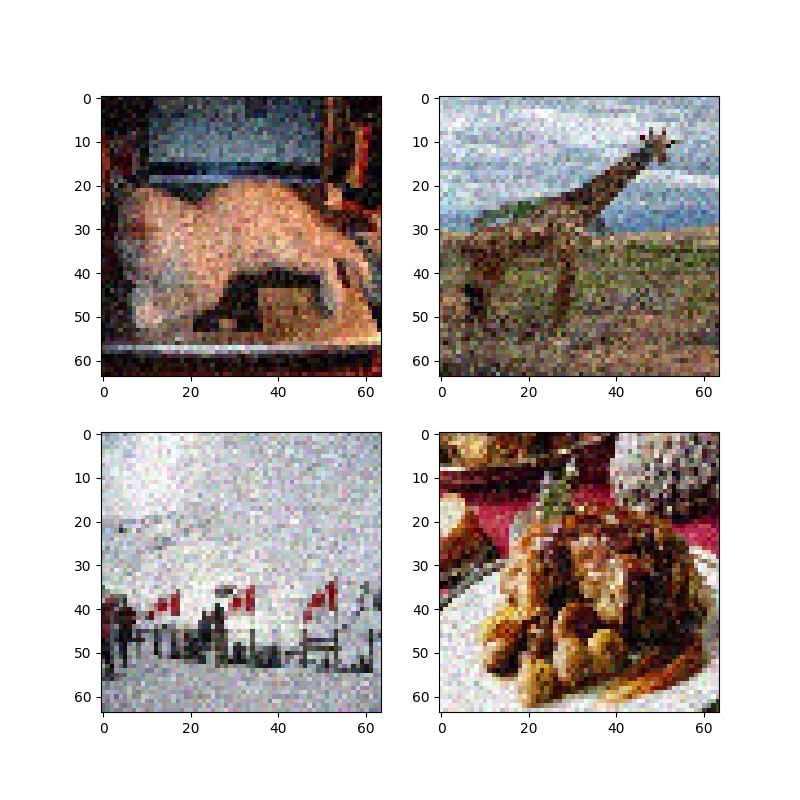

<IPython.core.display.Javascript object>


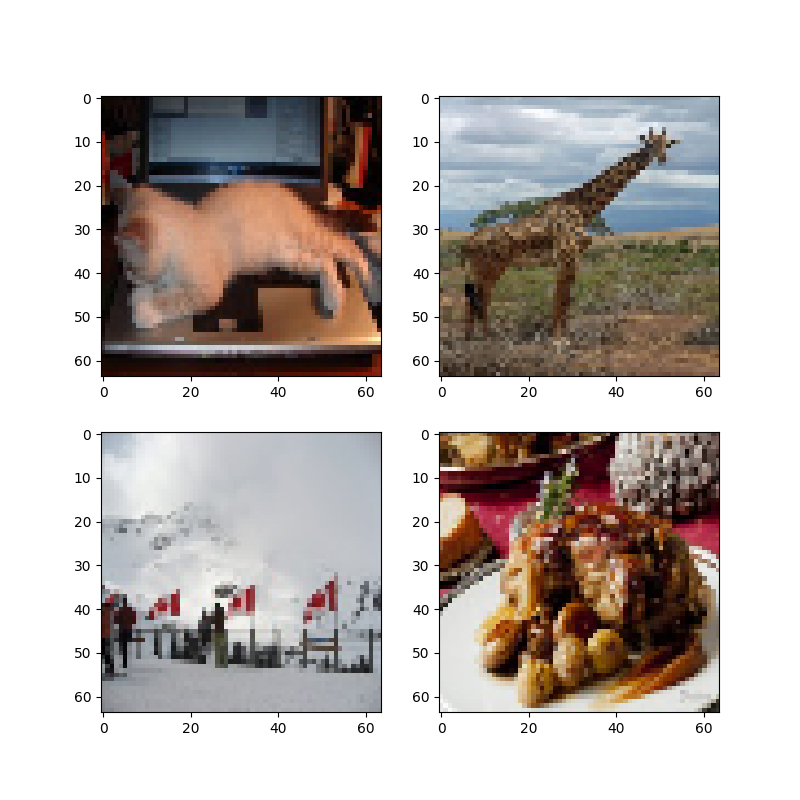

In [106]:
show_loaded_images()

In [ ]:
#autoencoders = train(number_of_trainings=10)
autoencoder = train(number_of_trainings=20)

(1050, 64, 64, 3)
(450, 64, 64, 3)
(1050, 64, 64, 3)
(450, 64, 64, 3)
Train on 1050 samples, validate on 450 samples
Epoch 1/30
1040/1050 [============================>.] - ETA: 0s - loss: 1.4479
Epoch 00001: val_loss improved from inf to 1.45380, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 9s 8ms/sample - loss: 1.4480 - val_loss: 1.4538
Epoch 2/30
1030/1050 [============================>.] - ETA: 0s - loss: 1.4409
Epoch 00002: val_loss did not improve from 1.45380
1050/1050 [==============================] - 5s 5ms/sample - loss: 1.4406 - val_loss: 1.4584
Epoch 3/30
1030/1050 [============================>.] - ETA: 0s - loss: 1.4376
Epoch 00003: val_loss did not improve from 1.45380
1050/1050 [==============================] - 5s 5ms/sample - loss: 1.4352 - val_loss: 1.4593
Epoch 4/30
1040/1050 [============================>.] - ETA: 0s - loss: 1.4301
Epoch 00004: val_loss did not improve from 1.45380
1050/1050 [==============================] - 5s 

Epoch 2/30
1040/1050 [============================>.] - ETA: 0s - loss: 0.4174
Epoch 00002: val_loss improved from 0.36673 to 0.29780, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.4172 - val_loss: 0.2978
Epoch 3/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.3656
Epoch 00003: val_loss improved from 0.29780 to 0.25439, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.3655 - val_loss: 0.2544
Epoch 4/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.3270
Epoch 00004: val_loss improved from 0.25439 to 0.24049, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.3270 - val_loss: 0.2405
Epoch 5/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.2931
Epoch 00005: val_loss improved from 0.24049 to 0.21610, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================

1050/1050 [==============================] - 6s 5ms/sample - loss: 1.4454 - val_loss: 1.4532
Epoch 3/30
1030/1050 [============================>.] - ETA: 0s - loss: 1.4401
Epoch 00003: val_loss improved from 1.45316 to 1.45219, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 6s 5ms/sample - loss: 1.4395 - val_loss: 1.4522
Epoch 4/30
1030/1050 [============================>.] - ETA: 0s - loss: 1.4354
Epoch 00004: val_loss did not improve from 1.45219
1050/1050 [==============================] - 5s 5ms/sample - loss: 1.4349 - val_loss: 1.4529
Epoch 5/30
1030/1050 [============================>.] - ETA: 0s - loss: 1.4315
Epoch 00005: val_loss did not improve from 1.45219
1050/1050 [==============================] - 5s 5ms/sample - loss: 1.4312 - val_loss: 1.4543
Epoch 6/30
1040/1050 [============================>.] - ETA: 0s - loss: 1.4292
Epoch 00006: val_loss did not improve from 1.45219
1050/1050 [==============================] - 5s 5ms/sample - loss: 1

Epoch 17/30
1030/1050 [============================>.] - ETA: 0s - loss: 1.4047
Epoch 00017: val_loss improved from 1.43508 to 1.43473, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 1.4018 - val_loss: 1.4347
Epoch 18/30
1030/1050 [============================>.] - ETA: 0s - loss: 1.3991
Epoch 00018: val_loss improved from 1.43473 to 1.43446, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 1.4012 - val_loss: 1.4345
Epoch 19/30
1040/1050 [============================>.] - ETA: 0s - loss: 1.4010
Epoch 00019: val_loss improved from 1.43446 to 1.43310, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 1.4004 - val_loss: 1.4331
Epoch 20/30
1030/1050 [============================>.] - ETA: 0s - loss: 1.3950
Epoch 00020: val_loss improved from 1.43310 to 1.43259, saving model to ./encoder_rgb.hdf5
1050/1050 [==========================

Epoch 20/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 00020: val_loss improved from 0.00217 to 0.00211, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.0023 - val_loss: 0.0021
Epoch 21/30
1040/1050 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 00021: val_loss did not improve from 0.00211
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.0023 - val_loss: 0.0024
Epoch 22/30
1040/1050 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 00022: val_loss improved from 0.00211 to 0.00207, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.0023 - val_loss: 0.0021
Epoch 23/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00023: val_loss did not improve from 0.00207
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.0022 - val_loss: 0.0022
Epoch 24/30
1040/1050 [=

1030/1050 [============================>.] - ETA: 0s - loss: 0.0668
Epoch 00022: val_loss improved from 0.06524 to 0.06229, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.0667 - val_loss: 0.0623
Epoch 23/30
1040/1050 [============================>.] - ETA: 0s - loss: 0.0636
Epoch 00023: val_loss improved from 0.06229 to 0.05961, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 6s 5ms/sample - loss: 0.0636 - val_loss: 0.0596
Epoch 24/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.0611
Epoch 00024: val_loss improved from 0.05961 to 0.05721, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 6s 5ms/sample - loss: 0.0611 - val_loss: 0.0572
Epoch 25/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.0587
Epoch 00025: val_loss improved from 0.05721 to 0.05492, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5

Epoch 23/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.0071
Epoch 00023: val_loss improved from 0.00645 to 0.00629, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.0071 - val_loss: 0.0063
Epoch 24/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.0070
Epoch 00024: val_loss improved from 0.00629 to 0.00619, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.0070 - val_loss: 0.0062
Epoch 25/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.0069
Epoch 00025: val_loss improved from 0.00619 to 0.00613, saving model to ./encoder_rgb.hdf5
1050/1050 [==============================] - 5s 5ms/sample - loss: 0.0068 - val_loss: 0.0061
Epoch 26/30
1030/1050 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 00026: val_loss improved from 0.00613 to 0.00594, saving model to ./encoder_rgb.hdf5
1050/1050 [==========================

In [ ]:
artifact_encoder = autoencoder
predict(autoencoder)
